## DATA PREPROCESSING

In [ ]:
import scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

In [ ]:
# Load the dataset

df_train = pd.read_csv("/content/drive/MyDrive/archive/fraudTrain.csv")
df_test = pd.read_csv("/content/drive/MyDrive/archive/fraudTest.csv")

# merge the datasets
df = pd.concat([df_train, df_test],ignore_index=True)

In [ ]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
print(f" Shape: {df.shape}\n")
print(f" Data Types: {df.dtypes}\n")

 Shape: (1852394, 23)

 Data Types: Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object



In [ ]:

df['is_fraud'].value_counts(normalize=True) * 100

,proportion
is_fraud,
0,99.478999
1,0.521001


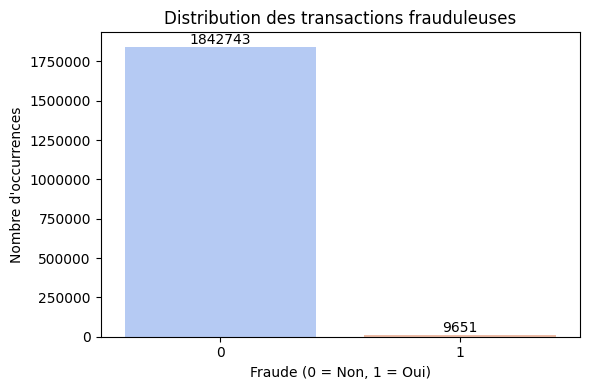

In [ ]:
import seaborn as sns
import matplotlib.ticker as ticker  # Import du module pour formater les axes

plt.figure(figsize=(6, 4))  # Taille du graphique
ax = sns.countplot(x='is_fraud', data=df, palette="coolwarm")

# Ajouter les annotations sur chaque barre
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

# 🔹 Fixer l'affichage des nombres entiers sur l'axe Y
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Distribution des transactions frauduleuses")
plt.xlabel("Fraude (0 = Non, 1 = Oui)")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()


In [ ]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["dob"] = pd.to_datetime(df["dob"])


Exploratory Data Analysis

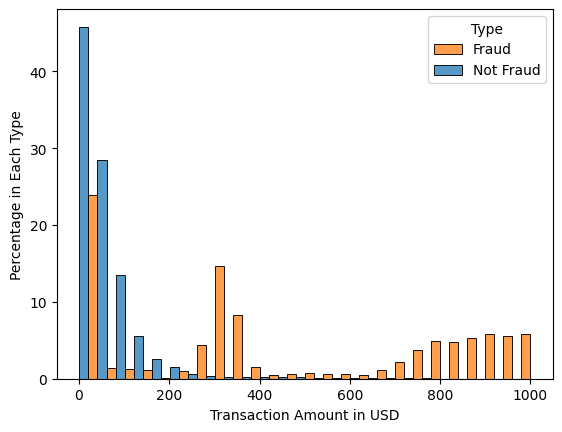

In [ ]:
#amount vs fraud
import seaborn as sns
ax=sns.histplot(x='amt',data=df[df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

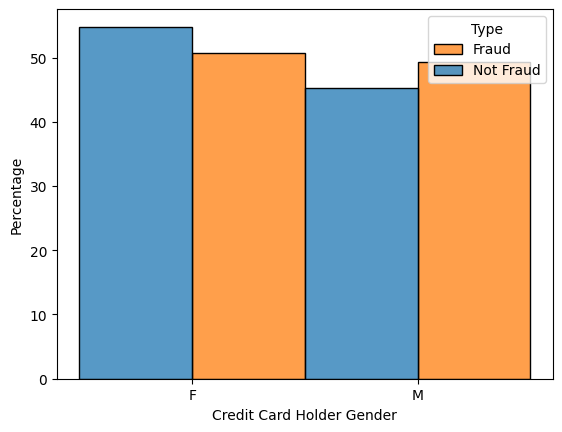

In [ ]:
#Gender vs Fraud
ax=sns.histplot(x='gender',data=df, hue='is_fraud',stat='percent',multiple='dodge',common_norm=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Credit Card Holder Gender')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

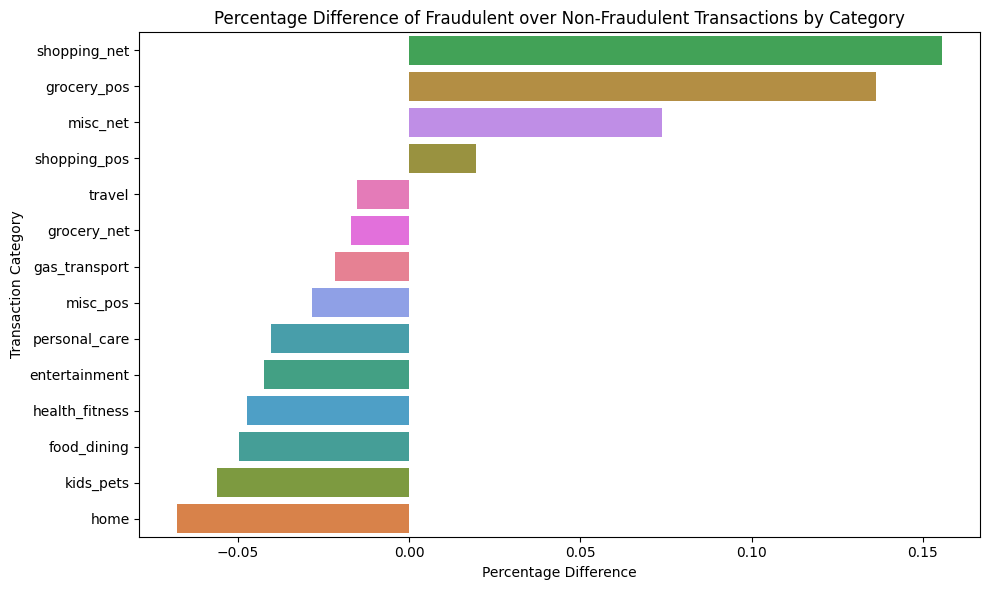

In [ ]:
#calculate the percentage difference
a=df[df['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=df[df['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']

ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

unique_categories = ab['category'].unique()
palette = sns.color_palette("husl", len(unique_categories))

color_dict = dict(zip(unique_categories, palette))

plt.figure(figsize=(10, 6))
ax = sns.barplot(y='category', x='diff', data=ab.sort_values('diff', ascending=False),
                 palette=[color_dict[cat] for cat in ab.sort_values('diff', ascending=False)['category']])

ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Percentage Difference of Fraudulent over Non-Fraudulent Transactions by Category')

plt.tight_layout()
plt.show()

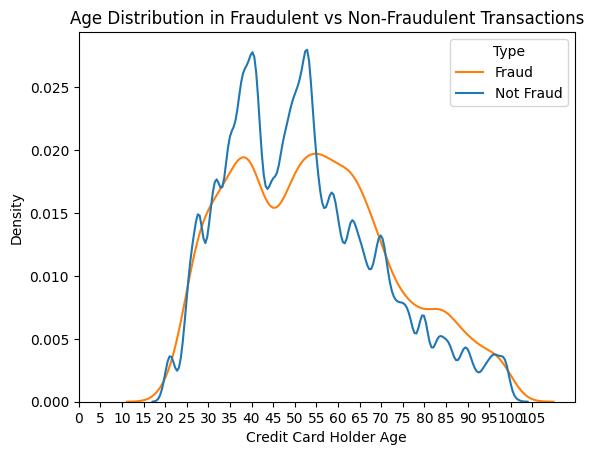

In [ ]:
#age vs fraud
import datetime as dt
df['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
ax=sns.kdeplot(x='age',data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,5))
plt.title('Age Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

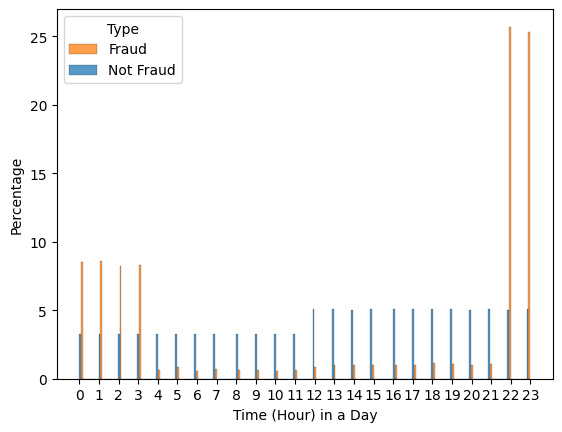

In [ ]:
#time in a day vs fraud
df['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
ax=sns.histplot(data=df, x="hour", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Time (Hour) in a Day')
plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

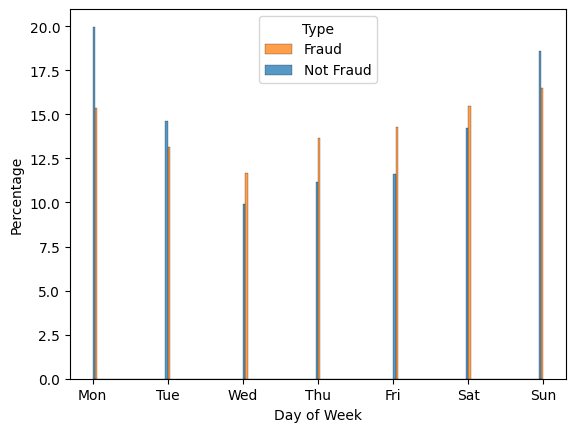

In [ ]:
#day of week vs fraud
df['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
ax=sns.histplot(data=df, x="day", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day of Week')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

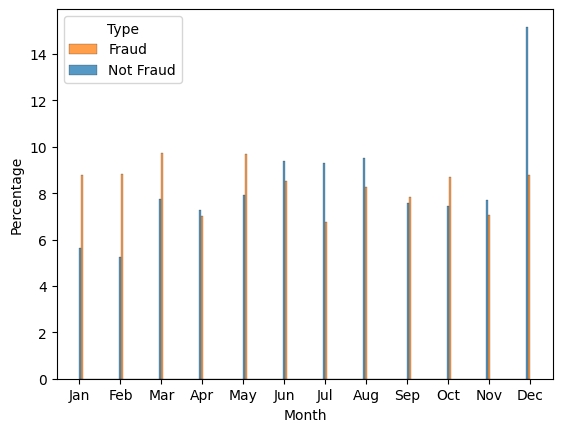

In [ ]:
#month vs fraud
df['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month
ax=sns.histplot(data=df, x="month", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

DATA CLEANING


In [ ]:


def clean_data(df):
    """
    Nettoie un DataFrame en supprimant les doublons, en traitant les valeurs manquantes,
    et en remplaçant les NaN dans les colonnes catégoriques par leur valeur la plus fréquente.
    """

    # Supprimer les doublons
    df = df.drop_duplicates()

    # Supprimer les lignes avec des valeurs manquantes (si elles en ont beaucoup)
    df = df.dropna(thresh=df.shape[1] * 0.5, axis=0)  # Supprime les lignes avec +50% de NaN

    # Remplacer les valeurs manquantes dans les colonnes catégoriques par le mode
    for col in df.select_dtypes(include=["object"]).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Supprimer les lignes restantes qui contiennent encore des valeurs manquantes
    df = df.dropna()

    print(f" {df.duplicated().sum()} doublons restants")
    print(f" {df.isnull().sum().sum()} valeurs manquantes restantes")
    return df


In [ ]:
df_clean = clean_data(df.copy())
print(f" Shape: {df_clean.shape}\n")

 0 doublons restants
 0 valeurs manquantes restantes
 Shape: (1852394, 27)



In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def encode_categorical(df):
    """
    Encode les colonnes catégoriques ('object') en valeurs numériques,
    sans modifier le DataFrame original.
    Retourne le DataFrame encodé + un dictionnaire des mappings.
    """
    df_encoded = df.copy()
    encoders = {}

    # Sélection automatique des colonnes de type 'object' (catégoriques)
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        #print(f"🔄 Encodage de la colonne : {col}")
        encoder = LabelEncoder()
        df_encoded[col] = encoder.fit_transform(df[col].astype(str))  # s'assurer que c'est bien du string
        encoders[col] = {
            label: int(code) for label, code in zip(encoder.classes_, encoder.transform(encoder.classes_))
        }

    print(f"\n✅ Encodage terminé pour {len(categorical_cols)} colonnes.")
    return df_encoded, encoders


In [ ]:
df_encoded, encoders = encode_categorical(df_clean.copy())

🔄 Encodage de la colonne : merchant
🔄 Encodage de la colonne : category
🔄 Encodage de la colonne : first
🔄 Encodage de la colonne : last
🔄 Encodage de la colonne : gender
🔄 Encodage de la colonne : street
🔄 Encodage de la colonne : city
🔄 Encodage de la colonne : state
🔄 Encodage de la colonne : job
🔄 Encodage de la colonne : trans_num

✅ Encodage terminé pour 10 colonnes.


In [ ]:
df_encoded.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,hour,day,month
0,0,2019-01-01 00:00:18,2703186189652095,514,8,4.97,164,18,0,576,...,1988-03-09,80326,1325376018,36.011293,-82.048315,0,37,0,1,1
1,1,2019-01-01 00:00:44,630423337322,241,4,107.23,312,161,0,439,...,1978-06-21,227462,1325376044,49.159047,-118.186462,0,47,0,1,1
2,2,2019-01-01 00:00:51,38859492057661,390,0,220.11,116,386,1,610,...,1962-01-19,1169030,1325376051,43.150704,-112.154481,0,63,0,1,1
3,3,2019-01-01 00:01:16,3534093764340240,360,2,45.00,165,468,1,945,...,1967-01-12,777909,1325376076,47.034331,-112.561071,0,58,0,1,1
4,4,2019-01-01 00:03:06,375534208663984,297,9,41.96,339,153,1,422,...,1986-03-28,1186866,1325376186,38.674999,-78.632459,0,39,0,1,1


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def scale_features(df, target_col="is_fraud", id_cols=None, categorical_cols=None):
    """
    - Normalise les colonnes numériques
    - Encode les colonnes catégorielles avec LabelEncoder
    - Ignore la colonne cible et les colonnes ID
    - Retourne le DataFrame transformé, le scaler et les encodeurs
    """
    df_scaled = df.copy()
    scaler = StandardScaler()
    encoders = {}

    # Définir les colonnes à exclure (ID, cible)
    if id_cols is None:
        id_cols = []
    if categorical_cols is None:
        categorical_cols = ['merchant', 'category', 'gender', 'job']  # par défaut

    exclude_cols = set(id_cols + [target_col])

    #  Encodage des colonnes catégorielles
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df_scaled[col] = le.fit_transform(df_scaled[col].astype(str))
            encoders[col] = le
            print(f"✅ Encodé : {col}")

    #  Colonnes numériques à normaliser (hors exclusions)
    numeric_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols_to_scale = [col for col in numeric_cols if col not in exclude_cols and col not in categorical_cols]

    # 🧪 Appliquer StandardScaler
    df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

    print(f"\n✅ Normalisation effectuée sur {len(numeric_cols_to_scale)} colonnes.")
    return df_scaled, scaler, encoders


In [ ]:
df_scaled, scaler, encoders = scale_features(df, target_col="is_fraud", id_cols=["trans_num"], categorical_cols=["merchant", "category", "gender", "job"])
df_scaled.head()

✅ Encodé : merchant
✅ Encodé : category
✅ Encodé : gender
✅ Encodé : job

✅ Normalisation effectuée sur 5 colonnes.


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,hour,day,month
0,0,2019-01-01 00:00:18,2703186189652095,514,8,-0.408741,Jennifer,Banks,0,561 Perry Cove,...,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,-0.495080,0.594463,0,37,0,1,1
1,1,2019-01-01 00:00:44,630423337322,241,4,0.233378,Stephanie,Gill,0,43039 Riley Greens Suite 393,...,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,2.080082,-2.031915,0,47,0,1,1
2,2,2019-01-01 00:00:51,38859492057661,390,0,0.942184,Edward,Sanchez,1,594 White Dale Suite 530,...,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,0.903268,-1.593535,0,63,0,1,1
3,3,2019-01-01 00:01:16,3534093764340240,360,2,-0.157381,Jeremy,White,1,9443 Cynthia Court Apt. 038,...,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,1.663928,-1.623084,0,58,0,1,1
4,4,2019-01-01 00:03:06,375534208663984,297,9,-0.176470,Tyler,Garcia,1,408 Bradley Rest,...,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,0.026642,0.842714,0,39,0,1,1


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

def balance_classes(df, target_col="is_fraud", method="smote", strategy=0.5, random_state=42):
    """
    Équilibre les classes avec SMOTE (sur-échantillonnage) ou RandomUnderSampler.
    - Convertit les colonnes catégorielles en numériques.
    - Ignore les colonnes datetime.
    """
    df = df.copy()

    # 1. Supprimer les colonnes datetime
    datetime_cols = df.select_dtypes(include=["datetime64[ns]"]).columns
    df.drop(columns=datetime_cols, inplace=True)

    # 2. Encoder les colonnes catégorielles textuelles
    for col in df.select_dtypes(include="object").columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    # 3. Vérifier que toutes les colonnes sont bien numériques
    assert all(df.dtypes != "object"), "Erreur : des colonnes non numériques restantes"

    # 4. Séparer features et target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    print("📊 Répartition AVANT équilibrage :")
    print(y.value_counts())

    # 5. Choisir le sampler
    if method == "smote":
        sampler = SMOTE(sampling_strategy=strategy, random_state=random_state)
    elif method == "under":
        sampler = RandomUnderSampler(sampling_strategy=strategy, random_state=random_state)
    else:
        raise ValueError("❌ Méthode inconnue. Utilisez 'smote' ou 'under'.")

    # 6. Appliquer le sampler
    X_resampled, y_resampled = sampler.fit_resample(X, y)

    print("\n📊 Répartition APRÈS équilibrage :")
    print(y_resampled.value_counts())

    return X_resampled, y_resampled


In [ ]:
X_balanced, y_balanced = balance_classes(df, target_col="is_fraud", method="smote")
df_balanced = pd.concat([X_balanced, y_balanced], axis=1)
print(df_balanced.shape)
df_balanced.head()


📊 Répartition AVANT équilibrage :
is_fraud
0    1842743
1       9651
Name: count, dtype: int64

📊 Répartition APRÈS équilibrage :
is_fraud
0    1842743
1     921371
Name: count, dtype: int64
(2764114, 25)


,Unnamed: 0,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,trans_num,unix_time,merch_lat,merch_long,age,hour,day,month,is_fraud
0,0,2703186189652095,514,8,4.97,164,18,0,576,532,...,372,80326,1325376018,36.011293,-82.048315,37,0,1,1,0
1,1,630423337322,241,4,107.23,312,161,0,439,619,...,431,227462,1325376044,49.159047,-118.186462,47,0,1,1,0
2,2,38859492057661,390,0,220.11,116,386,1,610,474,...,308,1169030,1325376051,43.150704,-112.154481,63,0,1,1,0
3,3,3534093764340240,360,2,45.00,165,468,1,945,84,...,330,777909,1325376076,47.034331,-112.561071,58,0,1,1,0
4,4,375534208663984,297,9,41.96,339,153,1,422,217,...,116,1186866,1325376186,38.674999,-78.632459,39,0,1,1,0


In [ ]:
df_balanced['is_fraud'].value_counts(normalize=True) * 100

,proportion
is_fraud,
0,66.666679
1,33.333321


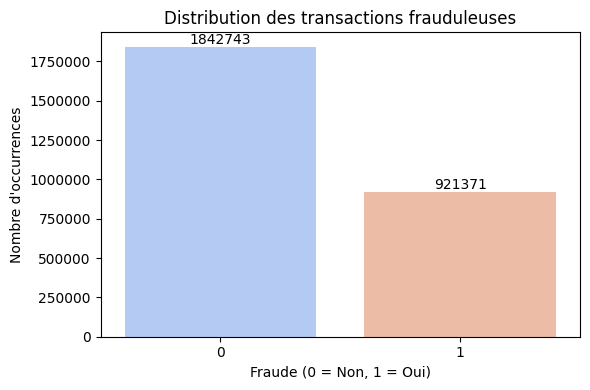

In [ ]:
import seaborn as sns
import matplotlib.ticker as ticker  # Import du module pour formater les axes

plt.figure(figsize=(6, 4))  # Taille du graphique
ax = sns.countplot(x='is_fraud', data=df_balanced, palette="coolwarm")

# Ajouter les annotations sur chaque barre
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

# 🔹 Fixer l'affichage des nombres entiers sur l'axe Y
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Distribution des transactions frauduleuses")
plt.xlabel("Fraude (0 = Non, 1 = Oui)")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()


In [ ]:
# transform df_balanced into csv et enregistrer

df_balanced.to_csv('df_balanced.csv', index=False)
